In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")


### Load and Prepare the Dataset

In [2]:
df=pd.read_excel("Ev Sales.xlsx")

In [3]:
df

,YEAR,2 W,3 W,4 W,BUS,TOTAL
0,2017-04-01,96,4748,198,0,5042
1,2017-05-01,91,6720,215,2,7028
2,2017-06-01,137,7178,149,1,7465
3,2017-07-01,116,8775,120,0,9011
4,2017-08-01,99,8905,137,0,9141
...,...,...,...,...,...,...
69,2023-01-01,64649,34308,3490,98,102545
70,2023-02-01,66033,35995,4850,99,106977
71,2023-03-01,86194,45225,8852,89,140360
72,2023-04-01,66755,38016,6193,84,111048


In [4]:
df.set_index('YEAR',inplace=True)

In [5]:
df.isna().sum()

2 W      0
3 W      0
4 W      0
BUS      0
TOTAL    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2017-04-01 to 2023-05-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   2 W     74 non-null     int64
 1   3 W     74 non-null     int64
 2   4 W     74 non-null     int64
 3   BUS     74 non-null     int64
 4   TOTAL   74 non-null     int64
dtypes: int64(5)
memory usage: 3.5 KB


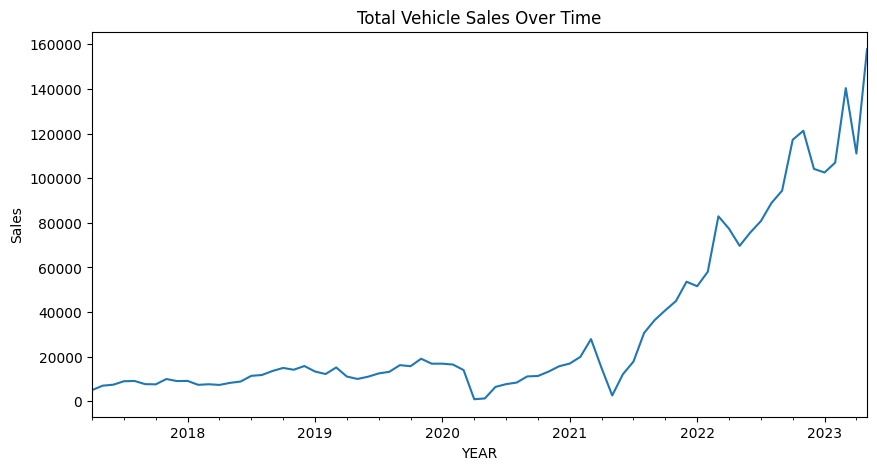

In [8]:
df['TOTAL'].plot(title='Total Vehicle Sales Over Time', figsize=(10, 5))
plt.ylabel("Sales")
plt.show()


- creating a time series plot to visualize the total vehicle sales over time, with appropriate axis labels and a title. The plot helps in understanding how sales have evolved over the period represented in the dataset.

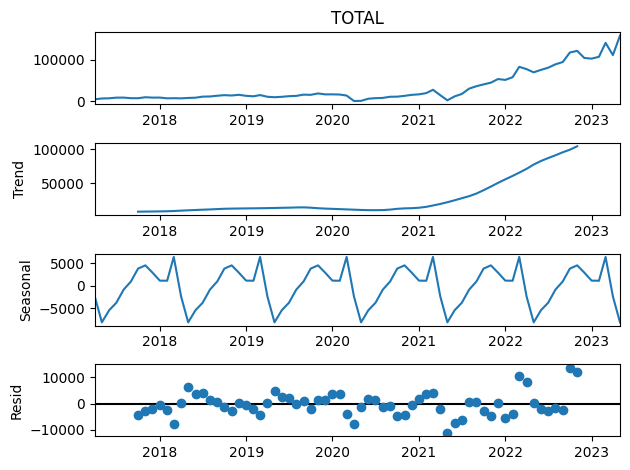

In [9]:
decomposition = seasonal_decompose(df['TOTAL'], model='additive', period=12)
decomposition.plot()
plt.show()


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

#### Test Stationarity
- Check if the time series is stationary using the Augmented Dickey-Fuller (ADF) test.



In [11]:
# ADF Test
adf_result = adfuller(df['TOTAL'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

if adf_result[1] > 0.05:
    print("Series is not stationary. Differencing is required.")
else:
    print("Series is stationary.")

ADF Statistic: 0.6513291923382588
p-value: 0.9888147911050046
Series is not stationary. Differencing is required.


#### First Differencing
- Perform the first differencing and retest for stationarity.

In [12]:
# Apply first differencing
df_diff1 = df['TOTAL'].diff().dropna()

# ADF Test on first-differenced data
result_diff1 = adfuller(df_diff1)
print(f"ADF Statistic (1st Differenced): {result_diff1[0]}")
print(f"p-value (1st Differenced): {result_diff1[1]}")
if result_diff1[1] > 0.05:
    print("Series is still not stationary. Further differencing required.")
else:
    print("First-order differenced series is stationary.")


ADF Statistic (1st Differenced): -0.40736322616954473
p-value (1st Differenced): 0.9088621041925403
Series is still not stationary. Further differencing required.


#### Second Differencing (if necessary)
- If the first differencing does not make the series stationary, apply second differencing.

In [13]:
# Apply second differencing
df_diff2 = df_diff1.diff().dropna()

# ADF Test on second-differenced data
result_diff2 = adfuller(df_diff2)
print(f"ADF Statistic (2nd Differenced): {result_diff2[0]}")
print(f"p-value (2nd Differenced): {result_diff2[1]}")
if result_diff2[1] > 0.05:
    print("Series is still not stationary. Investigate further.")
else:
    print("Second-order differenced series is stationary.")


ADF Statistic (2nd Differenced): -5.154597269857869
p-value (2nd Differenced): 1.087602774022146e-05
Second-order differenced series is stationary.


##### Fit ARIMA Model
- After achieving stationarity, fit an ARIMA model to the data.

In [14]:
# Fit ARIMA model
model_arima = ARIMA(df['TOTAL'], order=(1, 2, 1))  # Example: (p=1, d=2, q=1)
results_arima = model_arima.fit()

# Print model summary
print(results_arima.summary())


                               SARIMAX Results                                
Dep. Variable:                  TOTAL   No. Observations:                   74
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -759.672
Date:                Fri, 06 Dec 2024   AIC                           1525.344
Time:                        13:40:15   BIC                           1532.174
Sample:                    04-01-2017   HQIC                          1528.063
                         - 05-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4532      0.082     -5.539      0.000      -0.614      -0.293
ma.L1         -0.9141      0.056    -16.408      0.000      -1.023      -0.805
sigma2      1.063e+08   1.52e-10   6.99e+17      0.0

##### Fit SARIMAX Model
- If seasonality is suspected, extend the model to SARIMAX by adding seasonal parameters (P, D, Q, m).

In [15]:

# Fit SARIMAX model
model_sarimax = SARIMAX(df['TOTAL'], order=(1, 2, 1), seasonal_order=(1, 1, 1, 12))
results_sarimax = model_sarimax.fit()

# Print model summary
print(results_sarimax.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                   74
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                -634.056
Date:                            Fri, 06 Dec 2024   AIC                           1278.112
Time:                                    13:40:16   BIC                           1288.584
Sample:                                04-01-2017   HQIC                          1282.208
                                     - 05-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4168      0.197     -2.114      0.035      -0.803      -0.030
ma.L1         -0.9762      0.090   

##### Forecast Future Sales
- Generate and plot forecasts for the next 12 months.

In [16]:
# Forecast future values
forecast_steps = 12  # Number of future periods to forecast
forecast = results_sarimax.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()




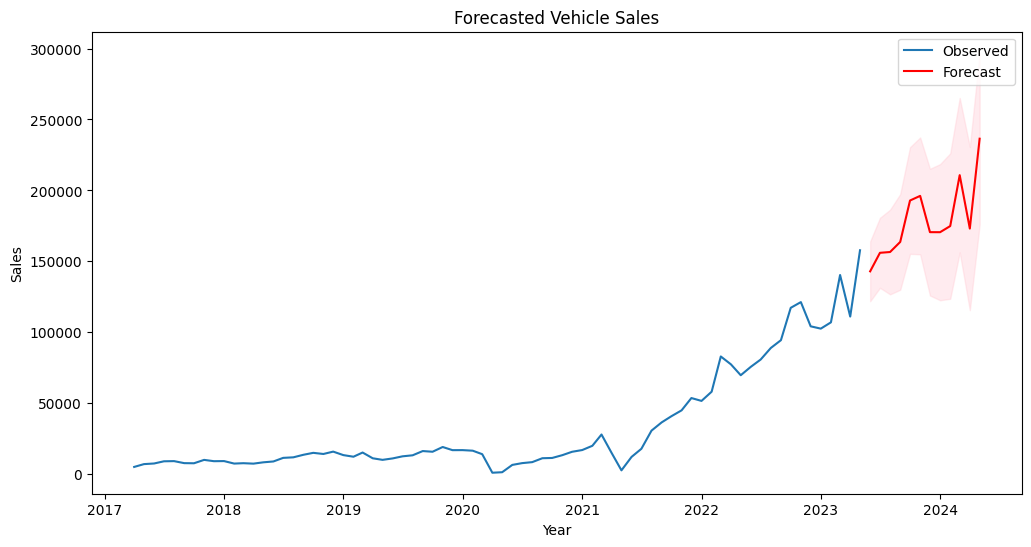

In [17]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(df['TOTAL'], label="Observed")
plt.plot(forecast_index, forecast_values, label="Forecast", color="red")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color="pink", alpha=0.3)
plt.title("Forecasted Vehicle Sales")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.legend()
plt.show()

In [18]:
forecast_df = pd.DataFrame({
    "Forecast": forecast_values,
    "Lower CI": forecast_ci.iloc[:, 0],
    "Upper CI": forecast_ci.iloc[:, 1]
}, index=forecast_index)

forecast_df.to_csv("forecasted_sales.csv")
print("Forecast saved to 'forecasted_sales.csv'")


Forecast saved to 'forecasted_sales.csv'


- This analysis focuses on the Electric Vehicle (EV) market dataset, which indicates an increasing trend in sales and market features over time. Based on the time series forecasting model (SARIMAX), future sales are predicted to continue rising, reflecting the growing demand for electric vehicles. The model accounts for seasonality and trend patterns, suggesting that the EV market will likely expand in the coming months. This insight supports the notion that the EV industry will experience sustained growth, with more emphasis on increasing features such as vehicle types, pricing, and consumer demographics